In [4]:
import numpy as np
import pandas as pd
import fipy as fp
from matplotlib import pyplot as plt
from matplotlib import cm
import os
import re
import h5py
import lncrna_analysis_helper as lh
from scipy.optimize import fsolve

In [5]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True

### Function to calculate condensate area from simulation data

In [30]:
def calculate_condensate_area(phi_p_0_list, c_max_list, target_directory, name_pattern, 
                                    stats_file = 'stats.txt', param_file='input_params.txt', 
                                    spatial_variables_file='spatial_variables.hdf5', nx=300, 
                                    dx=0.1, phi_p_thresh=0.25):
    
    """
    Function to read through directories that contain protein concentration data in spatial_variables.hdf5 files and 
    calculate the condensate area. A condensate is defined as a region in space where the protein concentration is larger
    than phi_p_thresh. This function searches sub-directories of a target_directory and extracts the spatial variables hdf5
    files from directories that correspond to the parameters c_max_list and phi_p_0_list and retrieves the data
    """
    
    condensate_area = np.zeros([len(phi_p_0_list), len(c_max_list)])
    
    for i in range(len(phi_p_0_list)):
        
        for j in range(len(c_max_list)):
    
            pattern = name_pattern.format(phi_p=phi_p_0_list[i],c_max=c_max_list[j])

            for root, dirs, files in os.walk(target_directory):

                regex = re.compile(pattern)
                match = re.search(regex, root)

                if match != None:
                    stats_file_name = root + '/' + stats_file
                    df_stats = pd.read_csv(stats_file_name, '\t')

                    # Read values of input parameters from param_file
                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                        nx = input_parameters['nx']
                        dx = input_parameters['dx']

                    mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                    spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file
                    with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                        counter = 1
                        while np.sum(sp_f['phi_p'][-counter]) == 0.0:
                            counter = counter + 1
                        phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][-counter])
                        indices_condensate = phi_p > phi_p_thresh
                        condensate_area[i,j] = np.sum(mesh.cellVolumes[indices_condensate]) 
                        condensate_area[i,j] = condensate_area[i,j]/(0.5*np.pi*input_parameters['sigma']**2)

    return condensate_area

### Class that describes the (Landau) free energy of the protein-solvent system

In [7]:
class protein_FE:
    """
    Class that defines the free energy of the protein-solvent system in the presence and absence of SE DNA
    """
    
    def __init__(self, params):
        """
        Initialize parameters associate with the above free energy expression
        """
        self.phi_p_low = params['phi_p_low']
        self.phi_p_hi = params['phi_p_hi']
        self.rho_p = params['rho_p']
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.spinodal_concs = self._get_spinodal_boundary()

    def mu_p(self, phi_p):
        """
        Return chemical potential as a function of phi_p
        """
        return 4*self.rho_p*(phi_p-self.alpha)*(phi_p-self.beta)*(phi_p-0.5*(self.alpha+self.beta))
    
    def _dmu_p_dphi_p(self, phi_p):
        """
        Function to compute the second derivative of the free energy with respect to phi_p
        """
        return 2*self.rho_p*(6*phi_p**2 - 6*phi_p*(self.alpha+self.beta) + self.alpha**2 + self.beta**2 
                             + 4*self.alpha*self.beta)
    
    def _get_spinodal_boundary(self):
        """
        Function the calculates the upper and lower concentrations bounds of the spinodal region
        """
        lower_bound_conc = fsolve(self._dmu_p_dphi_p, (self.phi_p_low,))
        upper_bound_conc = fsolve(self._dmu_p_dphi_p, (self.phi_p_hi,))
        return (lower_bound_conc, upper_bound_conc)

### Class that describes the FH free energy of the protein-solvent system

In [8]:
class protein_FE_FH:
    """
    Class that defines the FH free energy of the protein-solvent system in the presence and absence of SE DNA
    """
    
    def __init__(self, params):
        """
        Initialize parameters associate with the above free energy expression
        """
        self.phi_p_low = params['phi_p_low']
        self.phi_p_hi = params['phi_p_hi']
        self.N_P = params['N_P']
        self.chi = params['chi']
        self.spinodal_concs = self._get_spinodal_boundary()

    def mu_p(self, phi_p):
        """
        Return chemical potential as a function of phi_p
        """
        return (1.0+np.log(phi_p))/self.N_P - (1.0 + np.log(1-phi_p)) - 2*self.chi*phi_p
    
    def _dmu_p_dphi_p(self, phi_p):
        """
        Function to compute the second derivative of the free energy with respect to phi_p
        """
        return 1.0/(self.N_P*phi_p) + 1.0/(1.0-phi_p) - 2*self.chi
    
    def _get_spinodal_boundary(self):
        """
        Function the calculates the upper and lower concentrations bounds of the spinodal region
        """
        lower_bound_conc = fsolve(self._dmu_p_dphi_p, (self.phi_p_low,))
        upper_bound_conc = fsolve(self._dmu_p_dphi_p, (self.phi_p_hi,))
        return (lower_bound_conc, upper_bound_conc)

### Generate plots for thresholded condensate formation below saturation concentrations

In [9]:
# Calculate condensate areas for a range of values of phi_p0 and c_max

phi_p_0_list = [0.06, 0.1, 0.14, 0.18, 0.22]
c_max_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/VARY_PHIP_C_MAX/'
name_pattern_no_lncrna = "phi_p0_{phi_p}_.*_L_P_0.0_.*_M_rna_1.0_c_max_{c_max}$"

condensate_area = calculate_condensate_area(phi_p_0_list=phi_p_0_list, c_max_list=c_max_list,
                                            target_directory=target_directory, name_pattern=name_pattern_no_lncrna)


In [10]:
# Calculate the threshold c_max values for each protein concentration phi_p_0 below saturation

params = {
    'phi_p_low': 0.0,
    'phi_p_hi': 0.7,
    'rho_p': 3.0,
    'alpha': 0.2,
    'beta': 0.6,
    }

FE = protein_FE(params)

finer_phi_p_0_list = np.linspace(np.min(phi_p_0_list), np.max(phi_p_0_list), 20)
c_star_array = FE.mu_p(0.2) - FE.mu_p(finer_phi_p_0_list)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (53) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: 

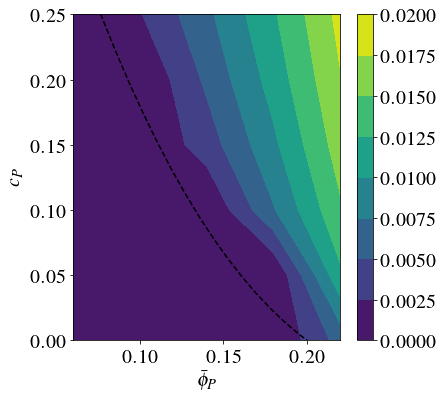

In [11]:
# Plot condensate area as a function of the two variables

phi_p_0, c_max = np.meshgrid(phi_p_0_list, c_max_list)

fig,axs = plt.subplots(1,1,figsize=(6,6))

contour = axs.contourf(phi_p_0, c_max, condensate_area.transpose()/(np.pi*5**2))
cbar = fig.colorbar(contour)
cbar.set_clim()

axs.plot(finer_phi_p_0_list, c_star_array, '--k')

axs.set_xlabel(r'$\bar{\phi}_P$')
axs.set_ylabel(r'$c_P$')
axs.set_xlim([0.06,0.22])
axs.set_ylim([0,0.25])

plt.savefig('20220206 - Plots for paper/cmax_phi_p_condensate.svg', format='svg', dpi = 600)

### Condensate area plots for FH model

In [103]:
# Calculate condensate areas for a range of values of phi_p0 and c_max

phi_p_0_list = [0.02, 0.03, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]
c_max_list = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern_no_lncrna = "phi_p0_{phi_p}_.*_M_rna_100.0_c_max_{c_max}$"

condensate_area = calculate_condensate_area(phi_p_0_list=phi_p_0_list, c_max_list=c_max_list,
                                            target_directory=target_directory, name_pattern=name_pattern_no_lncrna,
                                            phi_p_thresh=0.21)

In [104]:
# Calculate the threshold c_max values for each protein concentration phi_p_0 below saturation

params = {
    'phi_p_low': 0.05,
    'phi_p_hi': 0.55,
    'N_P': 5.0,
    'chi': 1.1,
    }

FE_FH = protein_FE_FH(params)

finer_phi_p_0_list = np.linspace(np.min(phi_p_0_list), np.max(phi_p_0_list), 20)
c_star_array = FE_FH.mu_p(FE_FH.spinodal_concs[0]) - FE_FH.mu_p(finer_phi_p_0_list)

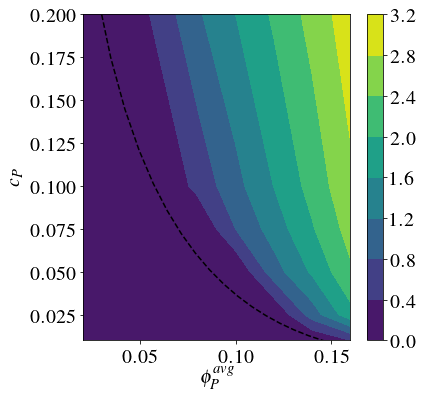

In [105]:
# Plot condensate area as a function of the two variables

phi_p_0, c_max = np.meshgrid(phi_p_0_list, c_max_list)

fig,axs = plt.subplots(1,1,figsize=(6,6))

contour = axs.contourf(phi_p_0, c_max, condensate_area.transpose())
cbar = fig.colorbar(contour)
cbar.set_clim()

axs.plot(finer_phi_p_0_list, c_star_array, '--k')

axs.set_xlabel(r'$\phi^{avg}_P$')
axs.set_ylabel(r'$c_P$')
axs.set_xlim([0.02,0.16])
axs.set_ylim([0.01,0.2])

plt.savefig('20220206 - Plots for paper/cmax_phi_p_condensate_FH.svg', format='svg', dpi = 600)

### Example plots of condensate formation

In [79]:
def get_protein_concentration_profile(phi_p_0, c_max, target_directory, name_pattern, 
                                    param_file='input_params.txt', spatial_variables_file='spatial_variables.hdf5', 
                                    nx=300, dx=0.1, phi_p_thresh=0.25):
    
    """
    Function to read through directories that contain protein concentration data in spatial_variables.hdf5 files and 
    calculate the condensate area. A condensate is defined as a region in space where the protein concentration is larger
    than phi_p_thresh. This function searches sub-directories of a target_directory and extracts the spatial variables hdf5
    files from directories that correspond to the parameters c_max and phi_p_0 and returns the protein 
    concentration profiles
    """
    
    condensate_area = np.zeros([len(phi_p_0_list), len(c_max_list)])
 
    pattern = name_pattern.format(phi_p=phi_p_0,c_max=c_max)

    for root, dirs, files in os.walk(target_directory):

        regex = re.compile(pattern)
        match = re.search(regex, root)

        if match != None:

            # Read values of input parameters from param_file
            input_param_file = root + '/' + param_file
            input_parameters = lh.input_parse(input_param_file)
            if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                nx = input_parameters['nx']
                dx = input_parameters['dx']

            mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
            spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file
            with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                counter = 1
                while np.sum(sp_f['phi_p'][-counter]) == 0.0:
                    counter = counter + 1
                phi_p = fp.CellVariable(mesh=mesh, value = sp_f['phi_p'][-counter])

    return mesh, phi_p

hi


/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (61) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (46) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (80) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: 

hi
hi
hi
hi
hi
hi
hi
hi


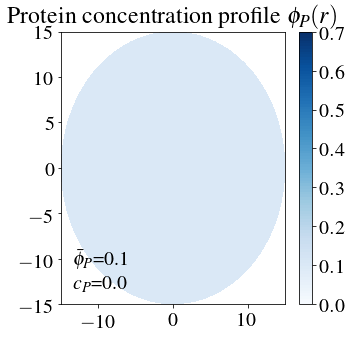

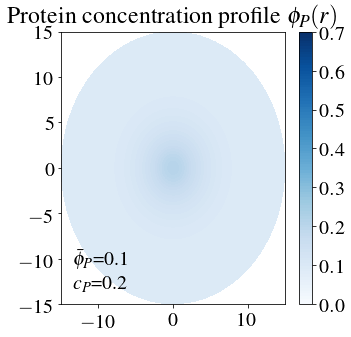

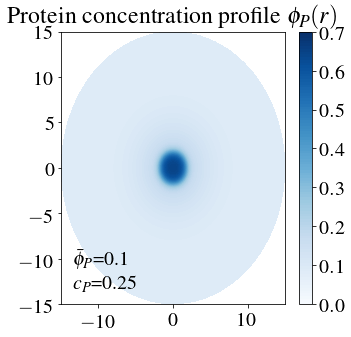

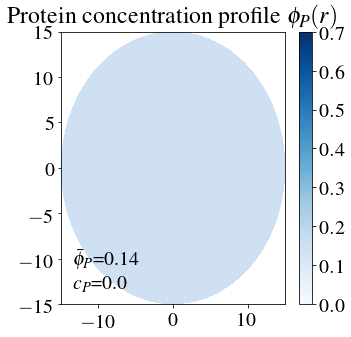

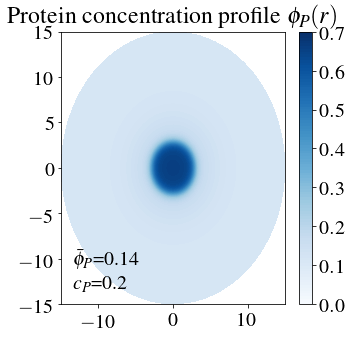

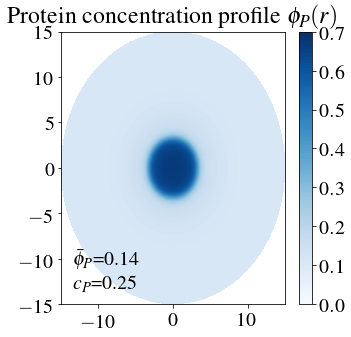

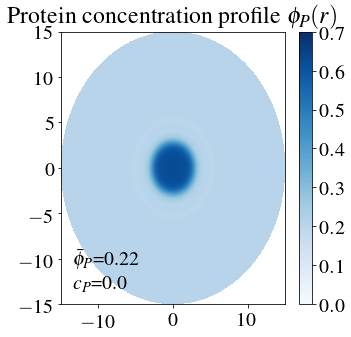

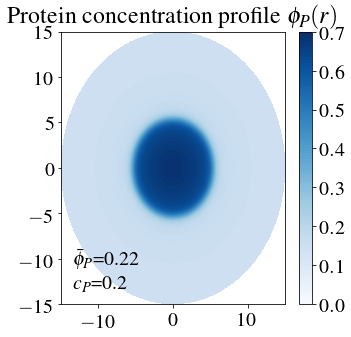

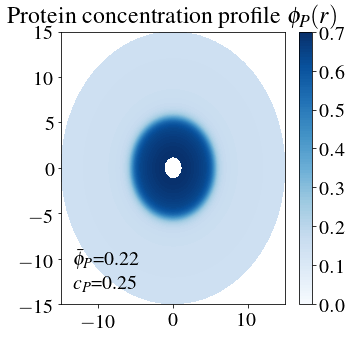

In [72]:
phi_p_0_list = [0.1, 0.14, 0.22]
c_max_list = [0.0, 0.2, 0.25]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/VARY_PHIP_C_MAX/'
name_pattern = "phi_p0_{phi_p}_.*_L_P_0.0_.*_M_rna_1.0_c_max_{c_max}$"

for i in range(len(phi_p_0_list)):
    for j in range(len(c_max_list)):
        mesh, phi_p = get_protein_concentration_profile(phi_p_0_list[i], c_max_list[j], target_directory, 
                                          name_pattern)
        fig, axs = plt.subplots(1,1,figsize=(5,5))
        cs = plt.tricontourf(mesh.x, mesh.y, phi_p, 
                        levels=np.linspace(0.0, 0.7, 100), cmap='Blues')
        fig.colorbar(cs, ticks=np.linspace(0, 0.7, 8))
        axs.set_title(r'Protein concentration profile $\phi_P(r)$')
        axs.text(0.05, 0.2, r'$\bar{\phi}_P$'+'={phi_p_0}'.format(phi_p_0=phi_p_0_list[i]), 
                 transform=axs.transAxes, fontsize=20, verticalalignment='top')
        axs.text(0.05, 0.1, r'$c_P$={c_max}'.format(c_max=c_max_list[j]), 
                 transform=axs.transAxes, fontsize=20, verticalalignment='top')
        plt.savefig('20220206 - Plots for paper/protein_concentration_profile_{phi_p}_{c_max}.svg'.
                    format(phi_p=phi_p_0_list[i], c_max=c_max_list[j]),
                   format = 'svg', dpi=1200)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (97) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (118) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (103) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


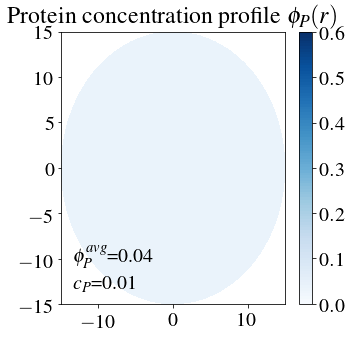

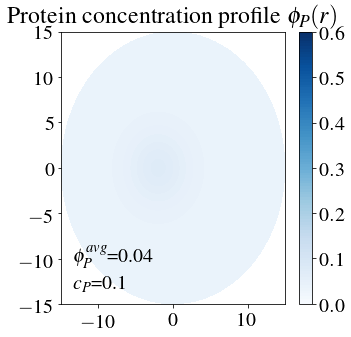

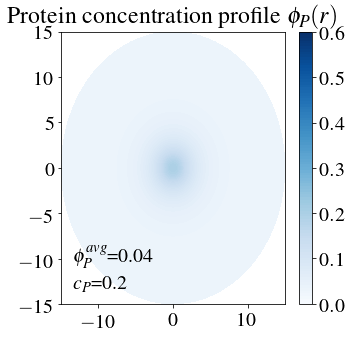

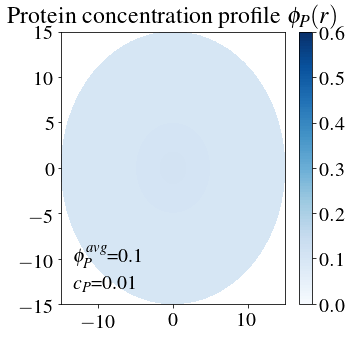

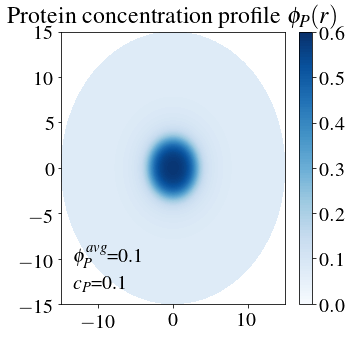

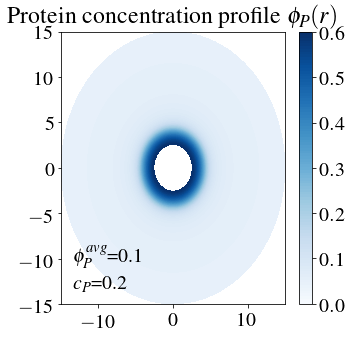

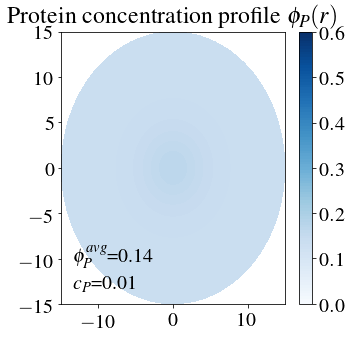

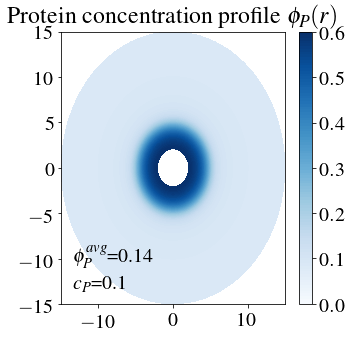

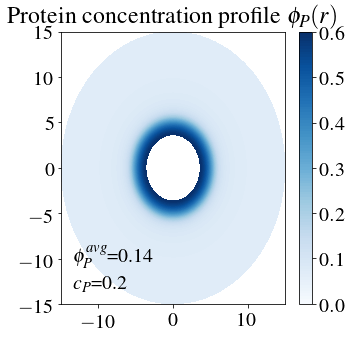

In [96]:
phi_p_0_list = [0.04, 0.1, 0.14]
c_max_list = [0.01, 0.1, 0.2]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{phi_p}_.*_c_max_{c_max}$"

for i in range(len(phi_p_0_list)):
    for j in range(len(c_max_list)):
        mesh, phi_p = get_protein_concentration_profile(phi_p_0_list[i], c_max_list[j], target_directory, 
                                          name_pattern)
        fig, axs = plt.subplots(1,1,figsize=(5,5))
        cs = plt.tricontourf(mesh.x, mesh.y, phi_p, 
                        levels=np.linspace(0.0, 0.6, 100), cmap='Blues')
        fig.colorbar(cs, ticks=np.linspace(0, 0.6, 7))
        axs.set_title(r'Protein concentration profile $\phi_P(r)$')
        axs.text(0.05, 0.2, r'$\phi^{avg}_P$'+'={phi_p_0}'.format(phi_p_0=phi_p_0_list[i]), 
                 transform=axs.transAxes, fontsize=20, verticalalignment='top')
        axs.text(0.05, 0.1, r'$c_P$={c_max}'.format(c_max=c_max_list[j]), 
                 transform=axs.transAxes, fontsize=20, verticalalignment='top')
        plt.savefig('20220206 - Plots for paper/FH_protein_concentration_profile_{phi_p}_{c_max}.svg'.
                    format(phi_p=phi_p_0_list[i], c_max=c_max_list[j]),
                   format = 'svg', dpi=1200)

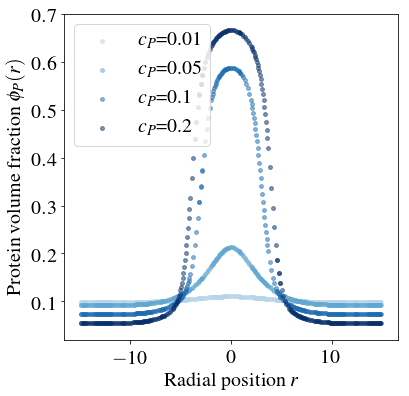

In [97]:
phi_p_0_list = [0.1]
c_max_list = [0.01, 0.05, 0.1, 0.2]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{phi_p}_.*_c_max_{c_max}$"

cmap = plt.get_cmap('Blues')
color_vals = np.linspace(0.3,1.0,len(c_max_list))

fig,axs = plt.subplots(1,1,figsize=(6,6))

for i in range(len(phi_p_0_list)):
    for j in range(len(c_max_list)):
        mesh, phi_p = get_protein_concentration_profile(phi_p_0_list[i], c_max_list[j], target_directory, 
                                          name_pattern)
        axs.scatter(np.array(mesh.y[(mesh.x<0.05) * (mesh.x>-0.05)]),
                np.array(phi_p[(mesh.x<0.05) * (mesh.x>-0.05)]), 
                label=r"$c_P$="+str(c_max_list[j]), s=15, alpha=0.5,
                   c=cmap(color_vals[j]))

axs.set_ylabel(r'Protein volume fraction $\phi_P(r)$')
axs.set_xlabel(r'Radial position $r$')
axs.legend()
plt.savefig("20220206 - Plots for paper/protein_conc_profile_different_c_phi_pt1.svg",format="svg")

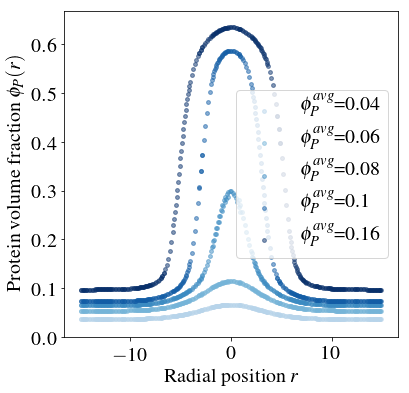

In [99]:
phi_p_0_list = [0.04, 0.06, 0.08, 0.1, 0.16]
c_max_list = [0.1]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/PURE_PROTEIN/MODIFIED_FH_TRIAL_VARY_PHIP_CMAX/'
name_pattern = "phi_p0_{phi_p}_.*_c_max_{c_max}$"

fig,axs = plt.subplots(1,1,figsize=(6,6))

cmap = plt.get_cmap('Blues')
color_vals = np.linspace(0.3,1.0,len(phi_p_0_list))

for i in range(len(phi_p_0_list)):
    for j in range(len(c_max_list)):
        mesh, phi_p = get_protein_concentration_profile(phi_p_0_list[i], c_max_list[j], target_directory, 
                                          name_pattern)
        axs.scatter(np.array(mesh.y[(mesh.x<0.05) * (mesh.x>-0.05)]),
                np.array(phi_p[(mesh.x<0.05) * (mesh.x>-0.05)]), 
                label=r"$\phi^{avg}_P$="+str(phi_p_0_list[i]), s=15, alpha=0.5,
                   c=cmap(color_vals[i]))

axs.set_ylabel(r'Protein volume fraction $\phi_P(r)$')
axs.set_xlabel(r'Radial position $r$')
axs.legend()
plt.savefig("20220206 - Plots for paper/protein_conc_profile_different_phi_c_pt1.svg",format="svg")